## a) Download the data

In [1]:
import matplotlib.pyplot as plt
from pandas import DataFrame
import gzip
import json
from random import randint
import functools as ft
import struct
from collections import Iterable
from functools import reduce

<ipython-input-1-2e913f82a86c>:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


- Billede består af 28 times 28 pixles

## b) 

Make a function read_labels(filename) to read a file containing labels (integers 0-9) in the format described under "FILE FORMATS FOR THE MNIST DATABASE". The function should return a list of integers. Test your method on the files t10k-labels.idx1-ubyte.gz and train-labels.idx1-ubyte.gz (the first five values of the 10.000 values in t10k-labels.idx1-ubyte.gz are [7, 2, 1, 0, 4]). The function should check if the magic number of the file is 2049.


Hint: Open the files for reading in binary mode by providing open with the argument 'rb'. You can either uncompress the files using a program like 7zip, or work directly with the compressed files using the gzip module in Python. In particular gzip.open will be relevant. To convert 4 bytes to an integer int.from_bytes might become useful.

In [2]:
def read_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic  = int(struct.unpack('>I', f.read(4))[0])
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                             (magic))
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = label_data
        return [b for b in labels]

In [3]:
test = read_labels('t10k-labels-idx1-ubyte.gz')

print(f'The first five element: \n {test[:5]}')

The first five element: 
 [7, 2, 1, 0, 4]


### c)

Make a function read_images(filename) to read a file containing MNIST images in the format described under "FILE FORMATS FOR THE MNIST DATABASE". Test your method on the files t10k-images.idx3-ubyte.gz and train-images.idx3-ubyte.gz. The function should return a three dimensional list of integers, such that images[image][row][column] is a pixel value (an integer in the range 0..255), and 0 ≤ row, column < 28 and 0 ≤ image < 10000 for t10k-images.idx3-ubyte.gz. The function should check if the magic number of the file is 2051.

In [3]:
def read_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic  = int(struct.unpack('>I', f.read(4))[0])
        if magic != 2051:
            raise ValueError('Invalid magic number %d' %
                             (magic))
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        #images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        images = [b for b in image_data]
        S = image_count,row_count,column_count
        test = list(ft.reduce(lambda x, y: map(list, zip(*y*(x,))), (iter(images), *S[:0:-1])))
        return test

### c) 

Make a function plot_images(images, labels) to show a set of images and their corresponding labels as titles using imshow from matplotlib.pyplot. Show the first few images from t10k-images.idx3-ubyte.gz with their labels from t10k-labels.idx1-ubyte.gz as titles. Remember to select an appropriate colormap for imshow.

In [4]:
labels_t10k = read_labels('t10k-labels-idx1-ubyte.gz')
images_t10k = read_images('t10k-images-idx3-ubyte.gz')

In [5]:
def plot_images(images_t10k, labels_t10k):
    num = 8
    labels = labels_t10k[:num]
    images = images_t10k[:num]
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

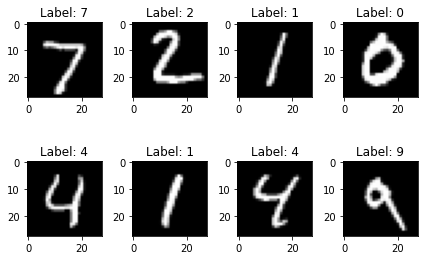

In [6]:
plot_images(images_t10k, labels_t10k)


The second group of tasks is to load and save existing linear classifier networks and to evaluate their performance, together with various helper functions. In the following we assume the vector b to be represented by a standard Python list of floats and the matrix A to be represented by a list-of-lists of floats.

### f)

Write functions linear_load(file_name) and linear_save(file_name, network) to load and save a linear classifier network = (A, b) using JSON. Test your functions on mnist_linear.weights Click for more options.

- https://www.kite.com/python/answers/how-to-create-a-filename-using-variables-in-python


In [7]:
def linear_load(filename):
    with open(filename) as json_file:
        indata = json.load(json_file)
    return indata


In [8]:
data = linear_load('mnist_linear (4).weights')
print(data[1])

[-0.45857512950897217, 0.4351542294025421, 0.10942944139242172, -0.3002070486545563, 0.06847649067640305, 0.9632328748703003, -0.1625736802816391, 0.4972691237926483, -1.0883114337921143, -0.2376248687505722]


In [9]:
def linear_save(file_name, network):
    file_name = file_name
    with open('%s-A.json' % file_name, 'w') as json_file:
        json.dump(network[0], json_file)
    with open('%s-b.json' % file_name, 'w') as json_file:
        json.dump(network[1], json_file)

In [10]:
linear_save('newfiletest', data)

### g)

Write function image_to_vector(image) that converts an image (list-of-lists) with integer pixel values in the range [0, 255] to an image vector (list) with pixel values being floats in the range [0, 1]
- https://necromuralist.github.io/neural_networks/posts/image-to-vector/


In [10]:
def image_to_vector(image):
    return sum(map(lambda a: image_to_vector(a) if isinstance(a,(list)) else [a],image),[])

def divide_255(image):
  return [i/255 for i in image]

### h) 
Write functions for basic linear algebra add(U, V), sub(U, V), scalar_multiplication(scalar, V) multiply(V, M), transpose(M) where V and U are vectors and M is a matrix. Include assertions to check if the dimensions of the arguments to add and multiply fit.

In [46]:
def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

def add(U, V): 
    assert len(U) == len(V), 'Dimension is different'
    adding = []
    zip_object = zip(U, V)
    for U_i, V_i in zip_object:
        adding.append(U_i + V_i)
    return adding

In [13]:
def sub(U, V):
    difference = []
    zip_object = zip(U, V)
    for U_i, V_i in zip_object:
        difference.append(U_i - V_i)
    return difference
V = [1,2,3]
U = [1,2,1]
print(f'Test if function works: \n {sub(U,V)}')


Test if function works: 
 [0, 0, -2]


In [14]:
def scalar_multiplication(scalar, V):
    l = [x * scalar for x in V]
    return l

scalar = 2
V = [1,2,3]

print(f'Test if function works: \n {scalar_multiplication(scalar,V)}')

Test if function works: 
 [2, 4, 6]


In [40]:
# Tvivl om hvilken dimension der skal være?
def multiply(V, M):
    result = []
    assert len(V) == len(M), 'Dimension is different'
    for i in range(len(M[0])): #this loops through columns of the matrix
        total = 0
        for j in range(len(V)): #this loops through vector coordinates & rows of matrix
            total += V[j] * M[j][i]
        result.append(total)
    return result

In [17]:
def transpose(M):
    result = [[M[j][i] for j in range(len(M))] for i in range(len(M[0]))]
    return result


[[1, 1, 1], [2, 2, 2], [3, 3, 1]]


### i)
Write a function mean_square_error(U, V) to compute the mean squared error between two vectors.
Examples: mean_square_error([1,2,3,4], [3,1,3,2]) shoule return 2.25.

- https://www.educative.io/edpresso/calculating-mean-squared-error-in-python

In [18]:
def mean_square_error(U, V):
    summation = 0  
    n = len(U) 
    for i in range (0,n):  
        difference = U[i] - V[i]  
        squared_difference = difference ** 2  
        summation = summation + squared_difference  
    return (summation / n )

In [19]:
mean_square_error([1,2,3,4], [3,1,3,2])

2.25

### j)

Write function a function argmax(V) that returns an index into the list V with maximal value (corresponding to numpy.argmax). E.g. argmax([6, 2, 7, 10, 5]) should return 3.

In [20]:
def argmax(a):
    return max(range(len(a)), key = lambda x: a[x])
a = [6, 2, 7, 10, 5]
argmax(a)

3

### k)

Implement a function categorical(label, classes=10) that takes a label from [0, 9] and returns a vector of length classes, with all entries being zero, except entry label that equals one. For an image with this label, the categorical vector is the expected ideal output of a perfect network for the image.
Example: categorical(3) should return [0,0,0,1,0,0,0,0,0,0].

In [22]:
def categorical(label, classes = 10):
    """Convert an iterable of indices to one-hot encoded labels."""
    lst = [0] * classes
    lst[label] = 1
    return lst
print(categorical(3))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


### l)

Write a function predict(network, image) that returns xA + b, given a network (A, b) and an image vector.

In [47]:
def predict(network, image):
    A, b = network
    prediction = add(multiply(divide_255(image_to_vector(image)), A), b)
    return prediction

In [48]:
print("Test if function work \n",argmax(predict(linear_load('mnist_linear (4).weights'),image= images_t10k[0:1])))

Test if function work 
 7


### m)

Create a function evaluate(network, images, labels) that given a list of image vectors and corresponding labels, returns the tuple (predictions, cost, accuracy), where predictions is a list of the predicted labels for the images, cost is the average of mean square errors over all input-output pairs, and accuracy the fraction of inputs where the predicted labels are correct. Apply this to the loaded network and the 10.000 test images in t10k-images. The accuracy should be around 92%, whereas the cost should be 230 (the cost is very bad since the network was trained to optimze the cost measure softmax).
Hint. Use your argmax function to convert network output into a label prediction.

In [49]:
def evaluate(network,image, labels, n):
  def predict3(image):
    A, b = network
    return add(multiply(image, A), b)
  adding = []
  for i in range(0, n):
    adding.append(divide_255(image_to_vector(image[i])))
  predic_eval = [argmax(predict3(i)) for i in  adding]  
  
  labels_adding = []
  for i in range(0, n):
    labels_adding.append(labels[i])
  
  mse = mean_square_error(labels_adding, predic_eval)
  
  accuracy = len([labels_adding[i] for i in range(0, \
             len(labels_adding)) if labels_adding[i] == predic_eval[i]]) /\
             len(labels_adding)
  
  return (predic_eval, mse, accuracy)

test_eval = evaluate(linear_load('mnist_linear (4).weights'),\
          images_t10k[0:10000],\
          labels_t10k[0:10000],\
          10000)
print(test_eval)

 2, 8, 4, 6, 8, 6, 5, 0, 0, 8, 7, 6, 1, 7, 1, 1, 2, 7, 4, 0, 0, 7, 7, 6, 3, 8, 6, 4, 2, 0, 7, 4, 0, 5, 7, 8, 2, 7, 6, 7, 1, 1, 2, 6, 6, 2, 9, 1, 9, 4, 8, 3, 6, 9, 5, 7, 6, 2, 4, 6, 7, 7, 0, 6, 6, 9, 9, 8, 3, 5, 3, 4, 9, 0, 0, 5, 2, 5, 0, 7, 1, 1, 1, 6, 7, 6, 7, 9, 6, 6, 4, 1, 4, 3, 1, 1, 2, 1, 4, 1, 0, 8, 7, 6, 3, 4, 0, 0, 6, 3, 3, 0, 7, 1, 7, 1, 1, 3, 1, 0, 9, 9, 7, 5, 4, 1, 4, 8, 9, 4, 3, 5, 1, 9, 8, 2, 9, 3, 9, 9, 0, 1, 0, 2, 9, 3, 9, 3, 3, 6, 2, 9, 9, 8, 3, 7, 4, 0, 4, 7, 8, 4, 9, 8, 1, 9, 7, 5, 9, 2, 8, 2, 2, 0, 2, 2, 3, 8, 4, 6, 8, 4, 8, 2, 4, 6, 7, 9, 3, 3, 9, 4, 3, 1, 9, 4, 7, 0, 5, 9, 6, 0, 4, 4, 4, 4, 6, 1, 2, 3, 2, 6, 4, 5, 9, 6, 8, 5, 6, 0, 5, 6, 4, 1, 8, 6, 8, 2, 5, 4, 5, 5, 4, 7, 9, 9, 7, 8, 2, 2, 3, 7, 0, 1, 8, 0, 7, 1, 9, 8, 7, 5, 5, 9, 1, 7, 5, 4, 3, 1, 2, 2, 1, 6, 6, 0, 1, 1, 4, 0, 7, 4, 2, 9, 0, 6, 4, 7, 6, 9, 5, 3, 4, 6, 5, 0, 1, 8, 8, 2, 3, 3, 5, 7, 8, 0, 8, 5, 7, 1, 1, 0, 1, 3, 7, 8, 5, 0, 7, 1, 1, 0, 1, 1, 4, 5, 2, 7, 6, 2, 3, 0, 2, 5, 5, 9, 6, 9, 7, 2, 1, 3, 6, 

### n)

Extend plot_images to take an optional argument prediction that is a list of predicted labels for the images, and visualizes if the prediction is correct or wrong. Test it on a set of images from t10k-images and their correct labels from t10k-labels.

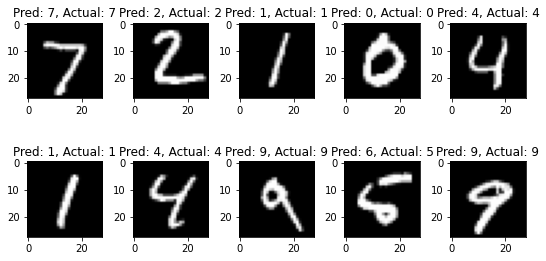

In [34]:
def plot_images(images_t10k, labels_t10k, prediction):
    num = 10
    labels = labels_t10k[:num]
    images = images_t10k[:num]
    prediction = prediction[0][0:num]
    num_row = 2
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f'Pred: {prediction[i]}, Actual: {labels[i]}')
    plt.tight_layout()
    plt.show()

plot_images(read_images('t10k-images-idx3-ubyte.gz'), \
            read_labels('t10k-labels-idx1-ubyte.gz'),\
            test_eval)

## o)

Column i of matrix A contains the (positive or negative) weight of each input pixel for class i, i.e. the contribution of the pixels towards the image showing the digit i. Use imshow to visualize each column (each column is a vector of length 784 that should be reshaped to an image of size 28 × 28)

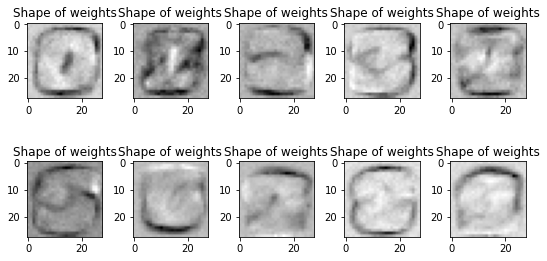

In [35]:
A, b = linear_load('mnist_linear (4).weights')

A_list = A

df = DataFrame(A_list,columns=['col0','col1','col2','col3','col4','col5',\
                'col6','col7','col8','col9'])

def reshape_list(list_to):
  S = 28, 28
  test_reshape = list(ft.reduce(lambda x, y: map(list, zip(*y*(x,))), (iter(list_to), *S[:0:-1])))
  return test_reshape

#def pandas_list(df):
save_object = []
for i in df:
  save_object.append(df[i].tolist())

new_shape_of_A = list(map(reshape_list, save_object))

num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
  ax = axes[i//num_col, i%num_col]
  ax.imshow(new_shape_of_A[i], cmap='gray')
  ax.set_title('Shape of weights')
plt.tight_layout()
plt.show()